In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2


class SingleImageDataset(Dataset):
    """
    The single image dataset
    """

    def __init__(self, image_path, transform, seed, train=True):
        """
        This is the single Image dataset. Note that the single image dataset contains only one image. Therefore, it is important note that it is important to use random cropping and other
        transforming methods to augment the dataset.
        
        :param image_path: This is the path of the data.
        :param transform: Normally, this is optional. However, it is required for this dataset given that it has only one image. Also, please use some corpping.
        """
        self.image_path = image_path
        self.image = io.imread(image_path)
        self.transform = transform
        self.seed = seed
        self.train = train

    def __len__(self):
        return 10000 // 2 if self.train else 4285 // 2

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if isinstance(idx, list):
            return [self.__getitem__(i) for i in idx]

        if not isinstance(idx, int):
            raise TypeError(f"`idx` must be an integer or a list but got {type(idx)}")

        # Set deterministic augmentation for given idx
        torch.manual_seed(self.seed + idx)
        return self.transform(self.image)


Image dimension: height=3744, width=5616, channel=3
Image dtype: dtype=dtype('uint8')


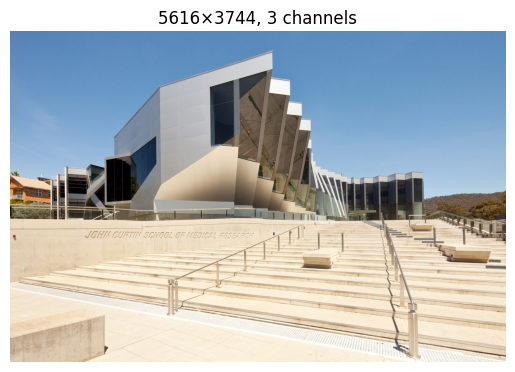

In [4]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

image: np.ndarray = io.imread('./data/jcsmr.jpg')
height, width = image.shape[:2]
channel = image.shape[2] if image.ndim == 3 else 1
dtype = image.dtype

print(f"Image dimension: {height=}, {width=}, {channel=}")
print(f"Image dtype: {dtype=}")

plt.imshow(image)
plt.title(f"{width}×{height}, {channel} channels")
plt.axis("off")
plt.show()

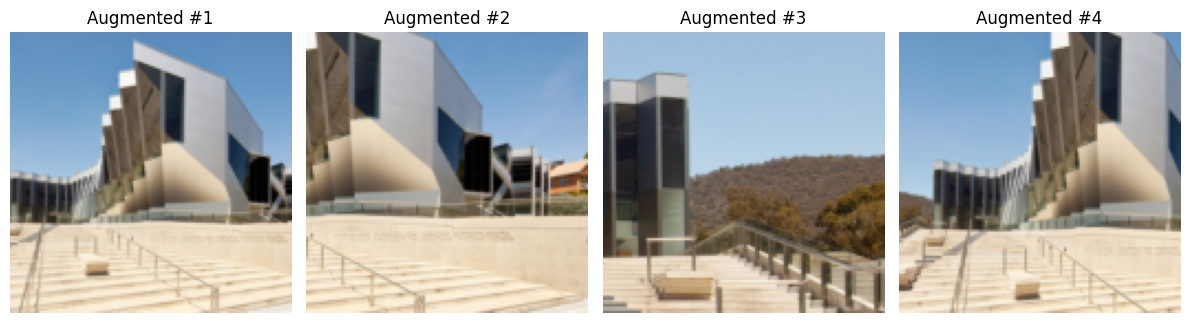

In [5]:
from torchvision.transforms.functional import to_pil_image

preview_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomResizedCrop(size=128, scale=(0.04, 0.75), ratio=(0.75, 2.0)),
    # v2.RandomPerspective(distortion_scale=0.3, p=0.5),    # This transformation causes unwanted padding, so I ended up disabling
    v2.RandomHorizontalFlip(p=0.5),
    # v2.RandomRotation(degrees=5),                         # This transformation causes unwanted padding, so I ended up disabling
    # v2.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.05),
])

# Generate and display augmented images
plt.figure(figsize=(12, 4))
for i in range(4):
    aug = preview_transform(image)
    img_pil = to_pil_image(aug)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img_pil)
    plt.title(f'Augmented #{i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
image_path = './data/jcsmr.jpg'
train_transform = v2.Compose([
    preview_transform,
    v2.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
])
train_dataset = SingleImageDataset(image_path, transform=train_transform, seed=42)

val_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomResizedCrop(size=128),
    v2.Normalize([0.5] * 3, [0.5] * 3),
])
val_dataset = SingleImageDataset(image_path, transform=val_transform, seed=1234567891, train=False)

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomResizedCrop(size=128),
])
test_dataset = SingleImageDataset(image_path, transform=test_transform, seed=9876543210, train=False)


In [7]:
from vqvae import VQVAE

def build_vae(
        # Shared args
        device, patch_nums=(1, 2, 3, 4, 5, 6, 8, 10, 13, 16),  # 10 steps by default
        # VQVAE args
        V=4096, Cvae=32, ch=160, share_quant_resi=4, z_channels=32, dropout=0.0
) -> VQVAE:
    # build models
    ddconfig = dict(
        dropout=dropout, ch=ch, z_channels=z_channels,
        in_channels=3, ch_mult=(1, 1, 2, 2), num_res_blocks=2,
        using_sa=False, using_mid_sa=False
    )
    vae_local = VQVAE(vocab_size=V, z_channels=Cvae, ch=ch, test_mode=True, share_quant_resi=share_quant_resi,
                      v_patch_nums=patch_nums, ddconfig=ddconfig).to(device)

    return vae_local


vae_config = {
    # Shared
    "device": torch.device("mps" if torch.mps.is_available() else "cpu"),
    # "patch_nums": (1, 2, 3, 4, 5, 6, 8, 10, 13, 16),
    "patch_nums": (1, 2, 4, 8, 16),
    "V": 512,
    "Cvae": 32,
    "ch": 32,
    "share_quant_resi": 4,
}

vae_local = build_vae(**vae_config)

In [8]:
training_config = {
    "train_batch_size": 32,
    "val_batch_size": 32,
    "lr": 1e-3,
    "epochs": 1000,
}

In [9]:
train_dataloader = DataLoader(train_dataset, pin_memory=False, batch_size=training_config['train_batch_size'])
val_dataloader = DataLoader(val_dataset, pin_memory=False, batch_size=training_config['val_batch_size'])

data_variance = np.var(image / 255.0)

In [10]:
import torch.optim

optimizer = optim.AdamW(vae_local.parameters(), lr=training_config['lr'])

In [11]:
def get_model_size_mb(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params * 4 / (1024 ** 2)  # Convert bytes to MB


model_size = get_model_size_mb(vae_local)
encoder_size = get_model_size_mb(vae_local.encoder)
quantizer_size = get_model_size_mb(vae_local.quantize)
decoder_size = get_model_size_mb(vae_local.decoder)
print(f"Estimated model size: {model_size:.2f} MB")
print(f"Estimated encoder size: {encoder_size:.2f} MB")
print(f"Estimated quantizer size: {quantizer_size:.2f} MB")
print(f"Estimated decoder size: {decoder_size:.2f} MB")

Estimated model size: 5.60 MB
Estimated encoder size: 2.20 MB
Estimated quantizer size: 0.20 MB
Estimated decoder size: 3.12 MB


In [12]:
def print_module_param_counts(model, name='', indent=0):
    total_params = 0
    sub_modules = dict(model.named_children())

    if not sub_modules:  # leaf node
        count = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print('  ' * indent + f'{name or model.__class__.__name__}: {count:,} params')
        return count

    print('  ' * indent + f'{name or model.__class__.__name__}:')
    for sub_name, sub_module in sub_modules.items():
        full_name = f'{name}.{sub_name}' if name else sub_name
        count = print_module_param_counts(sub_module, name=full_name, indent=indent + 1)
        total_params += count

    return total_params


# Assuming you have already built your model
total = print_module_param_counts(vae_local.encoder, name='Encoder')
print(f'\n[Total Encoder Params] {total:,}')

total = print_module_param_counts(vae_local.decoder, name='Decoder')
print(f'\n[Total Decoder Params] {total:,}')

Encoder:
  Encoder.conv_in: 896 params
  Encoder.down:
    Encoder.down.0:
      Encoder.down.0.block:
        Encoder.down.0.block.0:
          Encoder.down.0.block.0.norm1: 64 params
          Encoder.down.0.block.0.conv1: 9,248 params
          Encoder.down.0.block.0.norm2: 64 params
          Encoder.down.0.block.0.dropout: 0 params
          Encoder.down.0.block.0.conv2: 9,248 params
          Encoder.down.0.block.0.nin_shortcut: 0 params
        Encoder.down.0.block.1:
          Encoder.down.0.block.1.norm1: 64 params
          Encoder.down.0.block.1.conv1: 9,248 params
          Encoder.down.0.block.1.norm2: 64 params
          Encoder.down.0.block.1.dropout: 0 params
          Encoder.down.0.block.1.conv2: 9,248 params
          Encoder.down.0.block.1.nin_shortcut: 0 params
      Encoder.down.0.attn: 0 params
      Encoder.down.0.downsample:
        Encoder.down.0.downsample.conv: 9,248 params
    Encoder.down.1:
      Encoder.down.1.block:
        Encoder.down.1.block.0:
     

In [ ]:
vae_local.train()
train_res_recon_error = []
train_res_perplexity = []

for i in range(training_config['epochs']):
    data = next(iter(train_dataloader))
    data = data.to(device)
    optimizer.zero_grad()
    data_recon, _, vq_loss, perplexity = vae_local(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()
    
    # print(data_recon.shape)
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i + 1) % 100 == 0:
        print(f'{i + 1} iterations')
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity:  %.3f' % np.mean(train_res_perplexity[-100:]))
        print()


100 iterations
recon_error: 2.492
perplexity:  9.235

200 iterations
recon_error: 2.376
perplexity:  8.577

300 iterations
recon_error: 2.370
perplexity:  8.467

